In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns


In [89]:

crashes = pd.read_csv("./data/Traffic_Crashes_-_Crashes.csv.gz")
people = pd.read_csv("./data/Traffic_Crashes_-_People.csv.gz")
vehicles = pd.read_csv("./data/Traffic_Crashes_-_Vehicles.csv.gz")


c:\Users\sharo\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\Users\sharo\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (20,39,40,41,47,48,49,57,58,60) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [90]:
print(crashes.shape)
crashes.columns


(54959, 48)


Index(['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 

In [91]:
print(people.shape)
people.columns


(120061, 29)


Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'VEHICLE_ID',
       'CRASH_DATE', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',
       'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT',
       'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'HOSPITAL',
       'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY',
       'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE',
       'CELL_PHONE_USE'],
      dtype='object')

In [92]:
print(vehicles.shape)
vehicles.columns

(111727, 71)


Index(['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO',
       'UNIT_TYPE', 'NUM_PASSENGERS', 'VEHICLE_ID', 'CMRC_VEH_I', 'MAKE',
       'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT',
       'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER',
       'TOWED_I', 'FIRE_I', 'OCCUPANT_CNT', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY',
       'TOWED_TO', 'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I',
       'AREA_04_I', 'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I',
       'AREA_09_I', 'AREA_10_I', 'AREA_11_I', 'AREA_12_I', 'AREA_99_I',
       'FIRST_CONTACT_POINT', 'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO',
       'COMMERCIAL_SRC', 'GVWR', 'CARRIER_NAME', 'CARRIER_STATE',
       'CARRIER_CITY', 'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'UN_NO',
       'HAZMAT_PRESENT_I', 'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO',
       'MCS_REPORT_I', 'MCS_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I',
       'MCS_VIO_CAUSE_CRASH_I', 'IDOT_PERMIT_NO', 'WIDE_LOAD_I',
       'TRAILER1_

In [93]:
# 2. Create the SQL Engine in Memory (RAM)
conn = sqlite3.connect(':memory:')


In [94]:

# 3. Upload data to SQL (This takes a few seconds)
crashes.to_sql('Traffic_Crashes_Crashes', conn, index=False, if_exists='replace')
people.to_sql('Traffic_Crashes_People', conn, index=False, if_exists='replace')
vehicles.to_sql('Traffic_Crashes_Vehicles', conn, index=False, if_exists='replace')


c:\Users\sharo\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:2605: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [95]:

# 4. Paste the Query String
query = """SELECT 
    c.CRASH_RECORD_ID,
    c.PRIM_CONTRIBUTORY_CAUSE,   
    c.CRASH_HOUR,
    c.CRASH_DAY_OF_WEEK,
    c.CRASH_MONTH,
    c.POSTED_SPEED_LIMIT,
    c.WEATHER_CONDITION,
    c.LIGHTING_CONDITION,
    c.ROADWAY_SURFACE_COND,
    c.ROAD_DEFECT,
    c.TRAFFIC_CONTROL_DEVICE,
    c.FIRST_CRASH_TYPE,
    COALESCE(p.TOTAL_PEOPLE, 0) AS TOTAL_PEOPLE,
    p.AGE,
    COALESCE(p.DRUNK_DRIVERS_COUNT, 0) AS DRUNK_DRIVERS_COUNT,
    COALESCE(v.TOTAL_VEHICLES, 0) AS TOTAL_VEHICLES,
    COALESCE(v.DEFECTIVE_VEHICLES_COUNT, 0) AS DEFECTIVE_VEHICLES_COUNT

FROM Traffic_Crashes_Crashes c
LEFT JOIN (
    SELECT 
        CRASH_RECORD_ID,
        COUNT(PERSON_ID) AS TOTAL_PEOPLE,
        MAX(AGE) AS AGE,
        SUM(CASE WHEN PHYSICAL_CONDITION LIKE '%ALCOHOL%' THEN 1 ELSE 0 END) AS DRUNK_DRIVERS_COUNT
    FROM Traffic_Crashes_People
    GROUP BY CRASH_RECORD_ID
) p ON c.CRASH_RECORD_ID = p.CRASH_RECORD_ID
LEFT JOIN (
    SELECT 
        CRASH_RECORD_ID,
        COUNT(VEHICLE_ID) AS TOTAL_VEHICLES,
        SUM(CASE WHEN VEHICLE_DEFECT NOT IN ('NONE', 'UNKNOWN') THEN 1 ELSE 0 END) AS DEFECTIVE_VEHICLES_COUNT
    FROM Traffic_Crashes_Vehicles
    GROUP BY CRASH_RECORD_ID
) v ON c.CRASH_RECORD_ID = v.CRASH_RECORD_ID;
"""


aggregate, vehicles, 

In [96]:

# 5. Execute and get your Clean Dataset
data = pd.read_sql_query(query, conn)


In [97]:
data.shape

(54959, 17)

In [98]:
data.columns

Index(['CRASH_RECORD_ID', 'PRIM_CONTRIBUTORY_CAUSE', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'POSTED_SPEED_LIMIT',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'TRAFFIC_CONTROL_DEVICE', 'FIRST_CRASH_TYPE',
       'TOTAL_PEOPLE', 'AGE', 'DRUNK_DRIVERS_COUNT', 'TOTAL_VEHICLES',
       'DEFECTIVE_VEHICLES_COUNT'],
      dtype='object')

In [99]:
data.isnull().sum()

CRASH_RECORD_ID                0
PRIM_CONTRIBUTORY_CAUSE        0
CRASH_HOUR                     0
CRASH_DAY_OF_WEEK              0
CRASH_MONTH                    0
POSTED_SPEED_LIMIT             0
WEATHER_CONDITION              0
LIGHTING_CONDITION             0
ROADWAY_SURFACE_COND           0
ROAD_DEFECT                    0
TRAFFIC_CONTROL_DEVICE         0
FIRST_CRASH_TYPE               0
TOTAL_PEOPLE                   0
AGE                         9219
DRUNK_DRIVERS_COUNT            0
TOTAL_VEHICLES                 0
DEFECTIVE_VEHICLES_COUNT       0
dtype: int64

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54959 entries, 0 to 54958
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CRASH_RECORD_ID           54959 non-null  object 
 1   PRIM_CONTRIBUTORY_CAUSE   54959 non-null  object 
 2   CRASH_HOUR                54959 non-null  int64  
 3   CRASH_DAY_OF_WEEK         54959 non-null  int64  
 4   CRASH_MONTH               54959 non-null  int64  
 5   POSTED_SPEED_LIMIT        54959 non-null  int64  
 6   WEATHER_CONDITION         54959 non-null  object 
 7   LIGHTING_CONDITION        54959 non-null  object 
 8   ROADWAY_SURFACE_COND      54959 non-null  object 
 9   ROAD_DEFECT               54959 non-null  object 
 10  TRAFFIC_CONTROL_DEVICE    54959 non-null  object 
 11  FIRST_CRASH_TYPE          54959 non-null  object 
 12  TOTAL_PEOPLE              54959 non-null  int64  
 13  AGE                       45740 non-null  float64
 14  DRUNK_

In [103]:
median_age = data['AGE'].median()
data['AGE'] = data['AGE'].fillna(median_age)

In [105]:
data["AGE"].astype(np.int64)

0        40
1        45
2        54
3        74
4        39
         ..
54954    28
54955    29
54956    39
54957    63
54958    37
Name: AGE, Length: 54959, dtype: int64

In [ ]:
data.isnull().sum()

CRASH_RECORD_ID             0
PRIM_CONTRIBUTORY_CAUSE     0
CRASH_HOUR                  0
CRASH_DAY_OF_WEEK           0
CRASH_MONTH                 0
POSTED_SPEED_LIMIT          0
WEATHER_CONDITION           0
LIGHTING_CONDITION          0
ROADWAY_SURFACE_COND        0
ROAD_DEFECT                 0
TRAFFIC_CONTROL_DEVICE      0
FIRST_CRASH_TYPE            0
TOTAL_PEOPLE                0
AGE                         0
DRUNK_DRIVERS_COUNT         0
TOTAL_VEHICLES              0
DEFECTIVE_VEHICLES_COUNT    0
dtype: int64

In [ ]:
data.head()

,CRASH_RECORD_ID,PRIM_CONTRIBUTORY_CAUSE,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,ROAD_DEFECT,TRAFFIC_CONTROL_DEVICE,FIRST_CRASH_TYPE,TOTAL_PEOPLE,AGE,DRUNK_DRIVERS_COUNT,TOTAL_VEHICLES,DEFECTIVE_VEHICLES_COUNT
0,d4532856f89a7311fb6182ffef7cd3c27fdba4dba40671...,DISREGARDING TRAFFIC SIGNALS,23,3,12,35,SNOW,"DARKNESS, LIGHTED ROAD",SNOW OR SLUSH,NO DEFECTS,TRAFFIC SIGNAL,ANGLE,2,40.0,0,2,0
1,b938fbfa86d8b2d58d26656bf3266bc5452af63bd100ad...,UNABLE TO DETERMINE,23,3,12,30,SNOW,"DARKNESS, LIGHTED ROAD",SNOW OR SLUSH,NO DEFECTS,UNKNOWN,FIXED OBJECT,1,45.0,0,1,0
2,bb8c152ed4e0d29961e051b7d381508f1f9ea5aa051dbe...,UNABLE TO DETERMINE,22,3,12,30,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,SIDESWIPE SAME DIRECTION,2,54.0,0,2,0
3,40064b1f9d498293c9392d4c89bb60128409738a3c44d1...,DISREGARDING STOP SIGN,22,3,12,35,SNOW,"DARKNESS, LIGHTED ROAD",SNOW OR SLUSH,NO DEFECTS,STOP SIGN/FLASHER,ANGLE,4,74.0,0,2,0
4,efce3ab254c9daaacb6ce6a60e10e8cb8ca50ab3f7ea5b...,UNABLE TO DETERMINE,22,3,12,30,SNOW,"DARKNESS, LIGHTED ROAD",SNOW OR SLUSH,NO DEFECTS,TRAFFIC SIGNAL,TURNING,2,39.0,0,2,0


In [116]:
data["ROAD_DEFECT"].unique()

array(['NO DEFECTS', 'UNKNOWN', 'WORN SURFACE', 'OTHER',
       'DEBRIS ON ROADWAY', 'RUT, HOLES', 'SHOULDER DEFECT'], dtype=object)

### Visualization

What were the top 10 causes of accidents in Chicago?

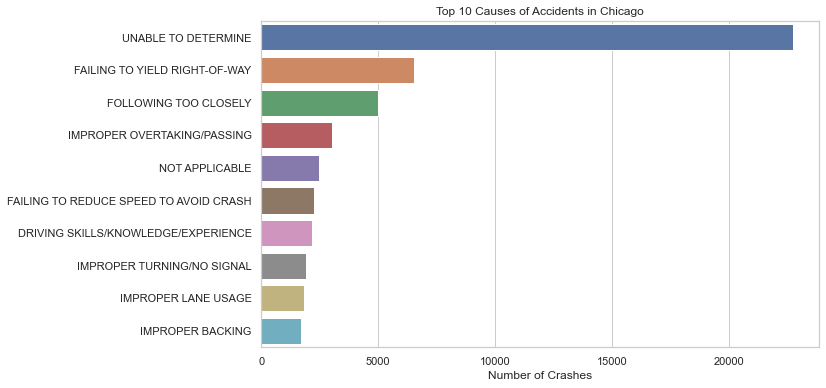

In [ ]:
sns.set_theme(style="whitegrid")
# Plot the Top 10 Causes
plt.figure(figsize=(10, 6))
top_causes = data['PRIM_CONTRIBUTORY_CAUSE'].value_counts().nlargest(10)
sns.barplot(x=top_causes.values, y=top_causes.index)
plt.title('Top 10 Causes of Accidents in Chicago')
plt.xlabel('Number of Crashes')
plt.show()

Most common age of drivers involved in accidents?


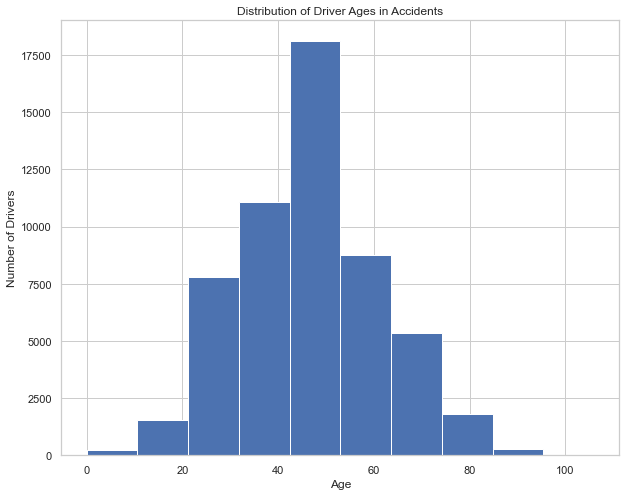

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))
plt.hist(data['AGE'])
plt.title('Distribution of Driver Ages in Accidents')
plt.xlabel('Age')	
plt.ylabel('Number of Drivers')
plt.show()

Number of accidents in certain hours of the day

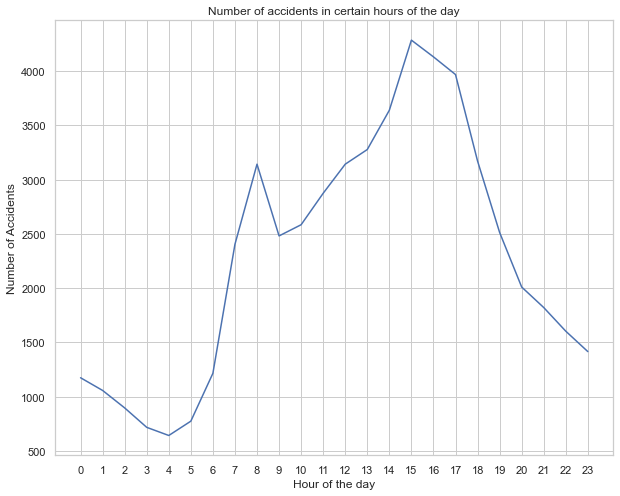

In [122]:
fig, figure= plt.subplots(figsize=(10,8))
plt.plot(data["CRASH_HOUR"].value_counts().sort_index())
plt.xlabel("Hour of the day")
plt.xticks(np.arange(24)) 
plt.ylabel("Number of Accidents")
plt.title("Number of accidents in certain hours of the day")
plt.show()

Many accidents occurred at the 15th hour (3pm) of the day. 

Why accidents peak at this hour? Is it because of traffic congestion during this time?people, and charges.

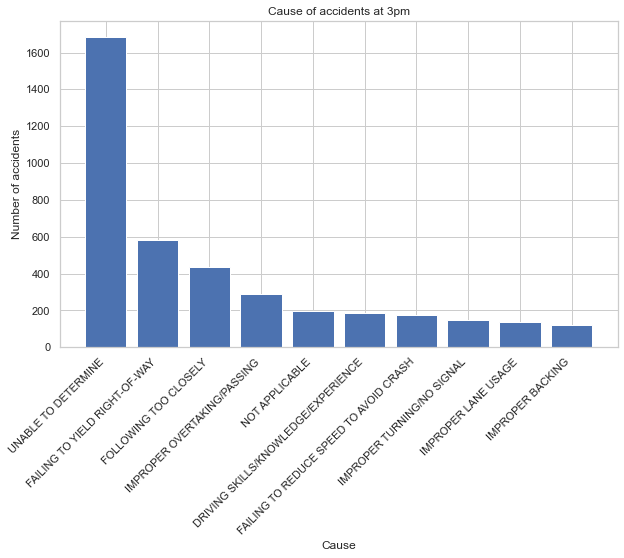

In [130]:
plt.figure(figsize=(10, 6))
pm3_accidents = data[data["CRASH_HOUR"] == 15]
cause_counts = pm3_accidents["PRIM_CONTRIBUTORY_CAUSE"].value_counts().sort_values(ascending=False).head(10)	
plt.bar(x=cause_counts.index, height=cause_counts.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Cause")
plt.ylabel("Number of accidents")
plt.title("Cause of accidents at 3pm")
plt.show()
